In [2]:
import os
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords#python -m nltk.downloader stopwords
import string

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jingdayang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import re
import time
import string
import warnings

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To mock web-browser and scrap tweets
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jingdayang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jingdayang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jingdayang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jingdayang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/jingdayang/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jingdayang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     

## import raw data 

In [4]:
tweets_df=pd.read_csv('../../data/01-modified-data/twitter_text_data.csv')
tweets_df=tweets_df.rename(columns = {'text':'tweets'})
tweets_df

,tweets
0,@TxCompleted I think Id be lying it I put anyt...
1,RT @Nanda__OCE: 🎁@satoshinftclub WHITELIST &am...
2,wl Notice Minting @eleven_eth @cryptobrighton ...
3,RT @MatCote3: @MoonlitMonkey69 @THORmaximalist...
4,"RT @BlockBet_: Did you know: On average, 900 $..."
...,...
1023,RT @MonstersRocket: We were somewhere around B...
1024,RT @purgeinventory: ⚔️ 6 DAYS UNTIL MINT! ⚔️\n...
1025,RT @sibu_nft: What to buy next?🥱\n\nStrongest ...
1026,WL Authorized Agent @jonooo__ @JustMotherly @...


## classfication with tweets with positve attitude and negitive attitude

In [5]:
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [6]:
sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,885
neg,143


In [7]:
tweets_df['attitude'] = sentiments_using_textblob
tweets_df

,tweets,attitude
0,@TxCompleted I think Id be lying it I put anyt...,pos
1,RT @Nanda__OCE: 🎁@satoshinftclub WHITELIST &am...,pos
2,wl Notice Minting @eleven_eth @cryptobrighton ...,pos
3,RT @MatCote3: @MoonlitMonkey69 @THORmaximalist...,pos
4,"RT @BlockBet_: Did you know: On average, 900 $...",neg
...,...,...
1023,RT @MonstersRocket: We were somewhere around B...,pos
1024,RT @purgeinventory: ⚔️ 6 DAYS UNTIL MINT! ⚔️\n...,pos
1025,RT @sibu_nft: What to buy next?🥱\n\nStrongest ...,pos
1026,WL Authorized Agent @jonooo__ @JustMotherly @...,pos


In [8]:
#data cleaning 
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [9]:
tweets_df['clean_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")
tweets_df['final_tweets'] = tweets_df['clean_tweets'].str.replace("[^a-zA-Z# ]", "")
stopwords_set = set(stopwords)
cleaned_tweets = []


for index, row in tweets_df.iterrows():
    
    words_without_stopwords = [word for word in row.final_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets_df['final_tweets'] = cleaned_tweets
tokenized_tweet = tweets_df['final_tweets'].apply(lambda x: x.split())
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['final_tweets'] = tokenized_tweet

/var/folders/q5/ngq63nrs4l504m7xnjms34_00000gp/T/ipykernel_50246/356389976.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['final_tweets'] = tweets_df['clean_tweets'].str.replace("[^a-zA-Z# ]", "")


In [10]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.final_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['final_tweets'] = cleaned_tweets

/Users/jingdayang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Attitude histogram')]

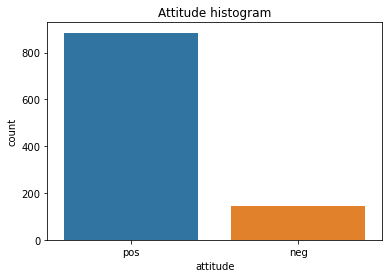

In [11]:
sns.countplot(tweets_df['attitude'],label='Count').set(title='Attitude histogram')

In [12]:
tweets_df['label']=np.where(tweets_df['attitude']=='pos',0,1)

In [23]:
tweets_df.to_csv (r'..//../data/01-modified-data/cleaned_twitter.csv', index = False, header=True)

In [14]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweets_df['final_tweets'])
X=X.toarray()

In [15]:
y=tweets_df['label']

In [16]:
#separate data two training data and test data
import random
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=66)

## Train a MultinomialNB model 

In [17]:

model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [18]:
yp_test=model.predict(x_test)
cm_matrix=confusion_matrix(y_test,yp_test)
cm_matrix

array([[133,  39],
       [  8,  26]])

Accuracy Score - 0.7718446601941747


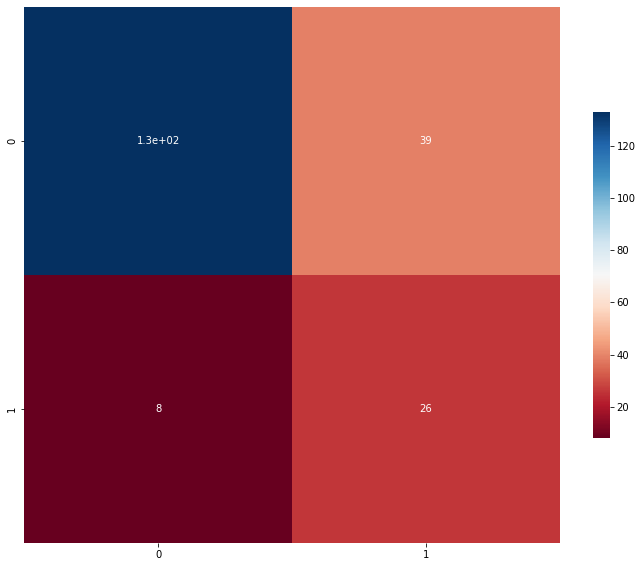

In [19]:

print(f'Accuracy Score - {accuracy_score(y_test, yp_test)}')
f, ax1 = plt.subplots(figsize = (12, 10))
ax1=sns.heatmap(cm_matrix,cmap="RdBu",annot=True,square=True,cbar_kws={'shrink': 0.6})
plt.show()

In [20]:
print(classification_report(y_test,yp_test))
#report_summ = classification_report(y_test,yp_test)
#report_summ = pd.DataFrame(report_summ)

              precision    recall  f1-score   support

           0       0.94      0.77      0.85       172
           1       0.40      0.76      0.53        34

    accuracy                           0.77       206
   macro avg       0.67      0.77      0.69       206
weighted avg       0.85      0.77      0.80       206



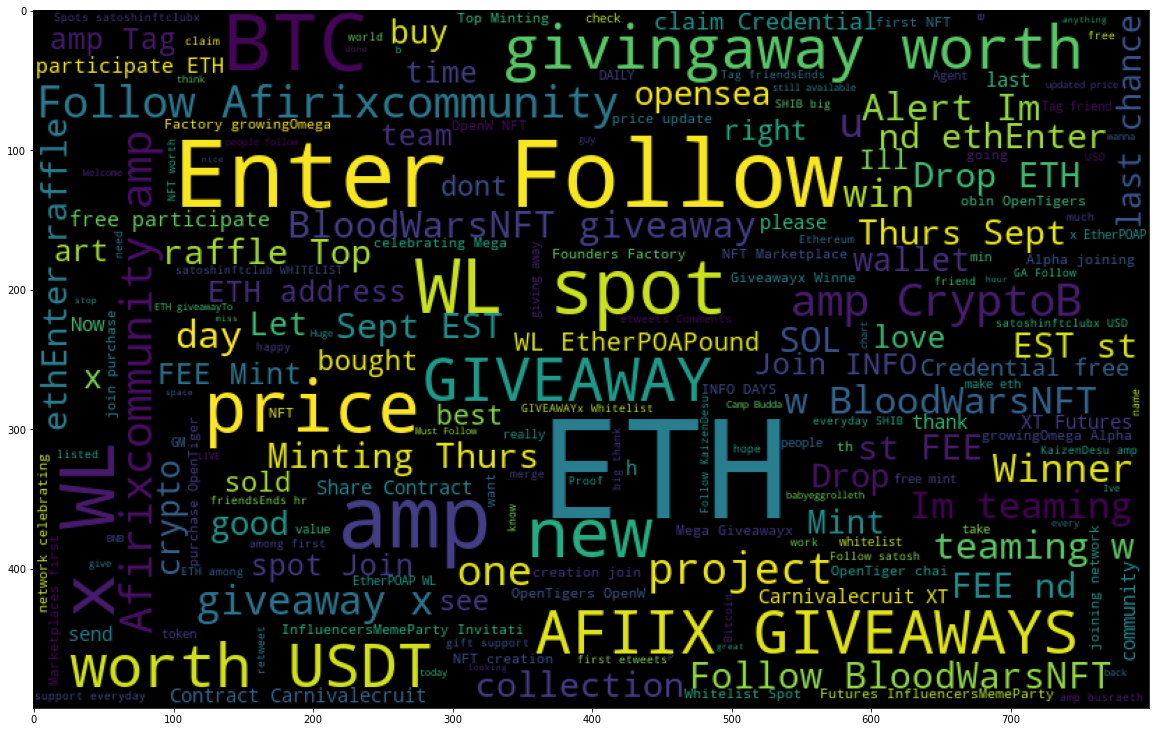

In [21]:
#positive word
postive_words = ' '.join([text for text in tweets_df['final_tweets'][tweets_df.attitude == 'pos']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5).generate(postive_words)
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud)
plt.show()

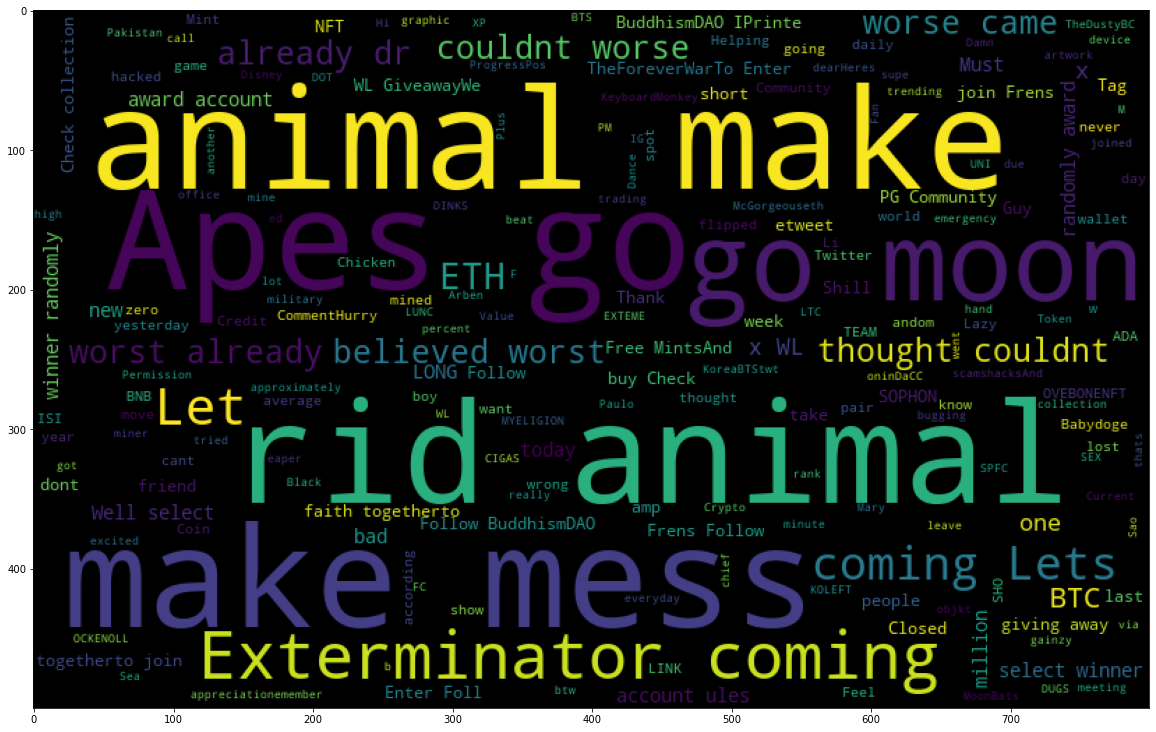

In [22]:
#neg word
negitve_words = ' '.join([text for text in tweets_df['final_tweets'][tweets_df.attitude == 'neg']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5).generate(negitve_words)
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud)
plt.show()